TEST LOADER FOR PHOIBOS 150 DATA

Typical structure 
/2020/01 January/Day 10/Raw Data/8874

Withing the folder of the scan number there is an info.txt and a scan
In THE AVG FOLDER there is a set of images, averaged over every acquisition cycle
IN THE RAW FOLDER there are single acquisition cycles (difference: in EPFL we added the "save every n cycle function"
this RAW folder also contains a "LUT.txt" file

In [81]:
#test the os package
import os

#get current directory
workingdir=os.getcwd()
#print(workingdir)
#navigate to example data
exampledatapath=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\\2020\\02 February\Day 17\Raw Data\9159'))
filelist=os.listdir(exampledatapath)
print("example data path= ",exampledatapath)
#this folders contains the AVG folder with the data, an info.txt vector and a scan vector
#filelist

#navigate to the image folder, for EPFL in the \AVG subfolder of the data (note that single scan cycles for partial load are in another subfolder - to be checked with Laurenz)
avgimagepath=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\\2020\\02 February\Day 17\Raw Data\9159\AVG'))
print("AVG images path= ",avgimagepath)
rawimagelist=os.listdir(avgimagepath)
#alternatively join the paths
#avgimagepath=os.path.join(exampledatapath,'AVG') 


example data path=  C:\Users\Michele\OneDrive\Documenti\GitHub\specsanalyzer-1\tests\data\dataEPFL\2020\02 February\Day 17\Raw Data\9159
AVG images path=  C:\Users\Michele\OneDrive\Documenti\GitHub\specsanalyzer-1\tests\data\dataEPFL\2020\02 February\Day 17\Raw Data\9159\AVG


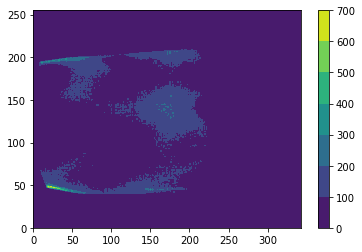

In [82]:
import numpy as np
import matplotlib.pyplot as plt
fname=os.path.join(avgimagepath,rawimagelist[0]) 
numpy_array = np.loadtxt(fname, delimiter="\t")

h = plt.contourf(numpy_array)
plt.colorbar()
#plt.xlim(120,150)
#plt.ylim(150,200)

one of the first operations should be to filter the image to remove the grid via FFT filtering

In [134]:
#load the module and import functions for reading the parameter table from the calib2d file

from importlib import reload

import specsanalyzer.convert
from specsanalyzer.convert import parameters_table

from specsanalyzer.convert import get_parameters
reload(specsanalyzer.convert)



<module 'specsanalyzer.convert' from 'c:\\users\\michele\\onedrive\\documenti\\github\\specsanalyzer-1\\specsanalyzer\\convert.py'>

In [135]:
#GET THE CALIBRATION FILE NAME FROM THE EXAMPLE FOLDER
calib2dfilename=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\phoibosEPFL.txt'))
#GET THE INFO FILE NAME FROM THE EXAMPLE FOLDER, SCAN 9159
#navigate to example data
exampledatapath=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\\2020\\02 February\Day 17\Raw Data\9159'))
filelist=os.listdir(exampledatapath)
str_match = list(filter(lambda x: 'info.txt' in x, filelist))
infofilename=os.path.join(exampledatapath,str_match[0]) 

calibrationmatrixfull=parameters_table(calib2dfilename)
calibrationmatrixfull

#now the calibration matrix contains only the Dass

(128, 5) (375, 5) (104, 5) (132, 5)
[[ 7.000e+00  1.003e+00  1.356e+00  1.334e+00  7.000e-02]
 [ 7.000e+00 -2.919e-02  4.922e-02  2.014e-01  7.000e-02]
 [ 7.000e+00 -8.050e-02  1.220e-02  6.046e-02  7.000e-02]
 ...
 [ 1.400e+01  6.753e-02  1.067e-01  1.475e-01  1.000e+01]
 [ 1.400e+01 -8.081e-02 -9.454e-02 -1.064e-01  1.000e+01]
 [ 1.400e+01  8.700e-03  1.423e-02  1.943e-02  1.000e+01]]


array([[ 7.000e+00,  1.003e+00,  1.356e+00,  1.334e+00,  7.000e-02],
       [ 7.000e+00, -2.919e-02,  4.922e-02,  2.014e-01,  7.000e-02],
       [ 7.000e+00, -8.050e-02,  1.220e-02,  6.046e-02,  7.000e-02],
       ...,
       [ 1.400e+01,  6.753e-02,  1.067e-01,  1.475e-01,  1.000e+01],
       [ 1.400e+01, -8.081e-02, -9.454e-02, -1.064e-01,  1.000e+01],
       [ 1.400e+01,  8.700e-03,  1.423e-02,  1.943e-02,  1.000e+01]])

In [6]:
calibrationmatrixinterp=get_parameters(infofilename,calib2dfilename)

In [7]:
#let's make and test the  polynomial fit
ek=10
ep=20
eshift=np.array([-0.05,0,0.05])
currentdamatrix=calibrationmatrixinterp
print(type(eshift))
da_energy=eshift*ep+ek*np.ones(eshift.shape)

def calculate_polynomial_Coef_Da(ek,ep,eshift,currentdamatrix):
    
    #get the Das from the damatrix
    #da1=currentdamatrix[0][:]
    #da3=currentdamatrix[1][:]
    #da5=currentdamatrix[2][:]
    #da7=currentdamatrix[3][:]

    #calcualte the energy values for each da, given the eshift
    da_energy=eshift*ep+ek*np.ones(eshift.shape)

    #create the polinomial coeffiecient matrix, each is a third order polinomial 
    
    dapolymatrix=np.zeros(currentdamatrix.shape)

    for i in range(0,currentdamatrix.shape[0]):
        #igor uses the fit poly 3, which should be a parabola
        dapolymatrix[i][:]=np.polyfit(da_energy, currentdamatrix[i][:], 2).transpose()
    return dapolymatrix

dapolymatrix=calculate_polynomial_Coef_Da(ek,ep,eshift,currentdamatrix)

<class 'numpy.ndarray'>


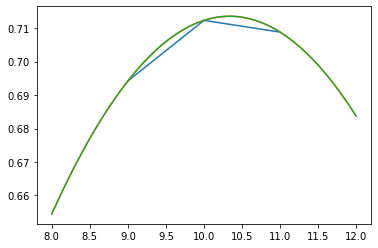

In [8]:
polcoef = np.polyfit(da_energy, currentdamatrix[0][:], 2)

plt.plot(da_energy,currentdamatrix[0][:])

energy_full=np.linspace(ek-ep*0.1,ek+ep*0.1,128)
polval=np.polyval(polcoef,energy_full)
polval2=np.polyval(dapolymatrix[0][:],energy_full)
plt.plot(energy_full,polval)
plt.plot(energy_full,polval2)

In [9]:
from specsanalyzer.convert import calculate_polynomial_coef_da
reload(specsanalyzer.convert)

<module 'specsanalyzer.convert' from 'c:\\users\\michele\\onedrive\\documenti\\github\\specsanalyzer-1\\specsanalyzer\\convert.py'>

In [10]:
dapolymatrix2=calculate_polynomial_coef_da(ek,ep,eshift,currentdamatrix)
dapolymatrix-dapolymatrix2

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [29]:
#let's now calculate the mcp_position_mm and zinner functions

def zinner1(ek,angle,dapolymatrix):
    #poly(D1, Ek )*(Ang) + 10^-2*poly(D3, Ek )*(Ang)^3 + 10^-4*poly(D5, Ek )*(Ang)^5 + 10^-6*poly(D7, Ek )*(Ang)^7
    out = 0
    
    for i in range(0,dapolymatrix.shape[0]):
        
        out = out + (10**(-2*i))*(angle**(1+2*i))*np.polyval(dapolymatrix[i][:],ek)
        
    return out

def zinner_diff1(ek,angle,dapolymatrix):
    #poly(D1, Ek ) + 3*10^-2*poly(D3, Ek )*(Ang)^2 + 5*10^-4*poly(D5, Ek )*(Ang)^4 + 7*10^-6*poly(D7, Ek )*(Ang)^6
    
    out = 0
    
    for i in range(0,dapolymatrix.shape[0]):
        
        out = out + (10**(-2*i))*(2*(i+1))*(angle**(2*i))*np.polyval(dapolymatrix[i][:],ek)
        
    return out


def mcp_position_mm1(ek,angle,ainner,dapolymatrix):
    
    mask=np.less_equal(np.abs(angle),ainner)
   
    #result=np.zeros(angle.shape)#ideally has to be evaluated on a mesh

    ainner_vec=np.ones(angle.shape)*ainner
    
    result = np.where(mask,
                      zinner1(ek,angle,dapolymatrix),
                      np.sign(angle)*zinner1(ek,angle,dapolymatrix)+
                      (np.abs(angle)-ainner_vec)*zinner_diff1(ek,angle,dapolymatrix))
   
    return result
#if np.greater_equal(np.abs(angle),ainner) : #values larger than the ainner have a different treatment
#    result= zinner(ek,angle,dapolymatrix)
#else:
#    result= np.sign(angle)*zinner(ek,angle,dapolymatrix) + (abs(angle)-ainner)*zinner_diff(ek,angle,dapolymatrix)

In [30]:

#mcp_position_mm(1,1,15,dapolymatrix)

angles=np.linspace(-18,18,1024)
energies=np.linspace(10,20,2048)

ainner=15

anglemesh,energymesh=np.meshgrid(angles,energies)
testimage=mcp_position_mm1(energymesh,anglemesh,15,dapolymatrix)



In [67]:
reload(specsanalyzer.convert)
from specsanalyzer.convert import mcp_position_mm

In [73]:
# For the example scan we have the following settings:
#'KineticEnergy': '35.500000',
# 'PassEnergy': '25.000000',
# eRange = -0.066 0.066 # Ep
 

angles=np.linspace(-20,20,1024)

energies=np.linspace(35.5-25*0.066,35.5+25*0.066,2048)

ainner=15

energymesh,anglemesh=np.meshgrid(energies,angles)
mask=np.less_equal(np.abs(anglemesh),ainner)
testimage=mcp_position_mm(energymesh,anglemesh,15,dapolymatrix)

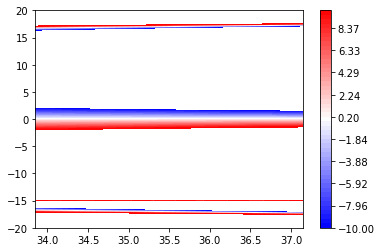

In [77]:
from matplotlib import cm

colorlevels=np.linspace(-10,10,50)

plt.contourf(energies,angles,testimage,cmap=cm.bwr,levels=colorlevels)
#plt.xlim(10,20)
#plt.ylim(-15,15)
#plt.clim(0,5)
plt.colorbar()

#not sure if this is correct.. but better than before

In [ ]:

""" NVAR PixelSize, magnification, E_Offset_px, Ang_Offset_px, LensMode, Ek, Ep, De1, aInner
	NVAR EkinLow, EkinHigh, AzimuthLow, AzimuthHigh
	NVAR Binning
	NVAR Edge_pos, Edge_Slope
	
	String Str
	// for full frames, if cropped in program we need to do something else?
	Variable nx_pixel=1376/Binning, ny_pixel=1040/Binning
	Make/O/N=(nx_pixel, ny_pixel) MCP_Position_mm_Matrix=NaN, Angular_Correction=NaN
	Make/O/N=(nx_pixel) w_E, E_Correction=NaN
	Make/O/N=(ny_pixel) w_Ang

	Variable Edge_Coef """


def calculate_matrix_correction1(ek,
                                 angle,
                                 ep,
                                 dapolymatrix,
                                 de1,
                                 erange,
                                 arange,
                                 ainner,
                                 nx_pixel,
                                 ny_pixel,
                                 pixelsize,
                                 binning,
                                 magnification):
    
	nx_bins=int(nx_pixel/binning)
	ny_bins=int(ny_pixel/binning)
	# this assumes the erange to be a 2d array -> do we ever need that?
	# erange was defined in the igor procedure Calculate_Da_values
	# it seems to be a constant, written in the calib2d file header
	ek_low = ek + erange[0]*ep
	ek_high = ek + erange[1]*ep 
	# assume an even number of pixels on the detector, seems reasonable
	ek_axis = np.linspace(ek_low,ek_high,nx_bins)
	
	#we need the arange as well as 2d array
	#arange was defined in the igor procedure Calculate_Da_values
	#it seems to be a constant, written in the calib2d file header
	#I decided to rename from "AzimuthLow"
	angle_low = arange[0]*1.2
	angle_high = arange[1]*1.2
	#check the effect of the additional range x1.2;
	#this is present in the igor code
	angle_axis =  np.linspace(angle_low,angle_high,ny_bins)

	
 	#the original program defines 2 waves, 
	mcp_position_mm_matrix=np.zeros([nx_bins,ny_bins])
	angular_correction_matrix=np.zeros([nx_bins,ny_bins])
	e_correction=np.zeros(ek_axis.shape)
	
	#let's create a meshgrid for vectorized evaluation
	ek_mesh,angle_mesh=np.meshgrid(ek_axis,angle_axis)
 
	mcp_position_mm_matrix=mcp_position_mm(ek_mesh,angle_mesh,
												ainner,dapolymatrix)
	
	Ang_Offset_px=0 #add as optional input?
 
	angular_correction_matrix = ((mcp_position_mm_matrix
                              /magnification)/(pixelsize*binning)
                              + ny_pixel/2 + Ang_Offset_px)
	
	e_correction=1
 
	return mcp_position_mm_matrix

In [ ]:
#Hemispheriscal analyser properties, from calib
ek=10
ep=20
angle=11
de1=0.0030
erange=np.array([-0.066,0.066])
arange=np.array([-15,15])
ainner=15


#2d camera properties, from manifacturer/user 
nx_pixel=1376
ny_pixel=1040
binning=2
pixelsize= 0.00645
magnification = 4.54
wf = 4.2

mcp_position_mm_matrix=calculate_matrix_correction1(ek,
                                                    angle,
                                                    ep,
                                                    dapolymatrix,
                                                    de1,
                                                    erange,
                                                    arange,
                                                    ainner,
                                                    nx_pixel,
                                                    ny_pixel,
                                                    pixelsize,
                                                    binning,
                                                    magnification)

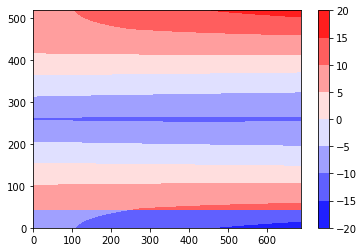

In [ ]:
from matplotlib import cm
plt.contourf(mcp_position_mm_matrix,cmap=cm.bwr)
plt.colorbar()

In [72]:
""" //~~~~~~~~~~~~~~~~~All the parameters needed to do the angular correction
//	LensMode			from user
//	Ek					from user
//	Ep					from user
//	E_Offset_px			from user
//	Ang_Offset_px		from user
//	Binning				from user
//	Edge_pos			from user
//	Edge_Slope			from user
//	eShift				from phoibos100.Calib2D
//	eRange				from phoibos100.Calib2D
//	aRange				from phoibos100.Calib2D
//	De1					from phoibos100.Calib2D
//	aInner				from phoibos100.Calib2D
//	Da3 - Da7			from phoibos100.Calib2D
//	WF					4.2eV or from CCDAcquire
//	PixelSize			0.00645 or from CCDAcquire
//	magnification			4.54 or from CCDAcquire
//~~~~~~~~~~~~~~~~~All the parameters needed to do the angular correction """


specsdictionary = {
  "lensmode": "WAM",
  "ek": 12,
  "ep": 20,
  "E_Offset_px" : 12
}
specsdictionary["lensmode"]



#here's a good way to create a dictionary from the info txt
def get_pair(line):
    key, sep, value = line.strip().partition(":")
    return key, value

with open(infofilename) as fd:    
    d = dict(get_pair(line) for line in fd)

d








{'ScanType': 'delay',
 'Averages': '10',
 'Repetitions': '1000',
 'LensMode': 'WideAngleMode',
 'VoltageRange': '400V',
 'Exposure': '200',
 'Gain': '0',
 'Binning': '2',
 'ROIbottom': '33',
 'ROItop': '1',
 'ROIright': '43',
 'ROIleft': '1',
 'DarkImg': '1',
 'KineticEnergy': '35.500000',
 'PassEnergy': '25.000000',
 'CoilCurrent': '3.000000',
 'WorkFunction': '0.000000',
 'DetectorVoltage': '1350.000000',
 'ScreenVoltage': '3000.000000',
 'ConversionVoltage': '-18.000000',
 'FocusDisplacement1': '0.001500',
 'FocusDisplacement2': '0.001500',
 'TimeZero': '281.044000'}

In [163]:
ek=float(d['KineticEnergy'])
ek

35.5

In [227]:
#the package regex seems to be the one for analysing the calib2d
#check this out
#  https://stackoverflow.com/questions/4146009/python-get-list-indexes-using-regular-expression
import re
h = open(calib2dfilename)
lines = h.readlines()

import re
fruit_list = ['raspberry', 'apple', 'strawberry']
berry_idx = [i for i, item in enumerate(fruit_list) if re.search('berry$', item)]



In [228]:
lines_wam_idx= [i for i, item in enumerate(lines) if re.search('WideAngleMode', item)]
#for i in lines_wam_idx:
wamline=lines[lines_wam_idx[2]]
wamlinestrip=wamline[:-2].replace("]", "")
wamlinestrip=wamlinestrip.replace("[", "")
rr= float(wamlinestrip.split("@")[1])
rr


0.1

In [229]:
rr=[]
lines_wam_idx= [i for i, item in enumerate(lines) if re.search('WideAngleMode', item)]
for i in lines_wam_idx:
    wamline=lines[i]
    if (wamline.find("@")!=-1):
        wamlinestrip=wamline[:-2].replace("]", "")
        wamlinestrip=wamlinestrip.replace("[", "")
        #print(wamlinestrip.split("@"))
        rr.append(float(wamlinestrip.split("@")[1]))
    
    
    
    
rr_array=np.array(rr)

In [151]:
rr=[]
lines_wam_idx= [i for i, item in enumerate(lines) if (re.search('WideAngleMode', item) and not(re.search('Super', item)))]


for i in range(1,len(lines_wam_idx)-1,1):
    
    currentblock_idx=lines_wam_idx[i]
    wamline=lines[currentblock_idx]
    if (wamline.find("@")!=-1):
        wamlinestrip=wamline[:-2].replace("]", "")
        wamlinestrip=wamlinestrip.replace("[", "")
        rr.append(float(wamlinestrip.split("@")[1]))
        
    #here we need to check 
    if (i+1)<=len(lines_wam_idx):
        nextblock_idx=lines_wam_idx[i+1]
    else:
        nextblock_idx=lines_wam_idx[i]
        
    if (wamline.find("defaults")!=-1):
        # default mode: loop until next section
        default=[]
        for j in range(currentblock_idx,nextblock_idx,1):
            default.append(lines[j])
    else:
        currentblock=[]
        for j in range(currentblock_idx+1,nextblock_idx-1,1):
            currentblock.append(lines[j])
    
    
rr_array=np.array(rr)

In [152]:
default

['[WideAngleMode defaults]\n',
 'aUnit  = "deg"\n',
 'aRange = -15 15\n',
 'eShift = -0.05 0 0.05 # Ep\n',
 'aGrid  = 1\n',
 '\n']

In [153]:
currentblock

['aInner = 14 # deg\n',
 'Da1 = 0.783 0.794 0.7933 # mm_z/deg^1\n',
 'Da3 = 0.06895 0.1055 0.1451 # mm_z/deg^3\n',
 'Da5 = -0.08245 -0.09305 -0.1034 # mm_z/deg^5\n',
 'Da7 = 0.009759 0.01415 0.0188 # mm_z/deg^7\n']

In [279]:
reload(specsanalyzer.convert)    
from specsanalyzer.convert import get_scanparameters_fromcalib2d
from specsanalyzer.convert import bisection
from specsanalyzer.convert import second_closest_rr

from specsanalyzer.convert import get_rr_da
from specsanalyzer.convert import get_da_block


In [221]:
rr=get_scanparameters_fromcalib2d(infofilename,calib2dfilename)
rr

array([ 0.1 ,  0.2 ,  0.3 ,  0.35,  0.42,  0.5 ,  0.55,  0.6 ,  0.7 ,
        0.75,  0.82,  0.9 ,  0.95,  1.  ,  1.5 ,  2.  ,  3.35,  3.42,
        3.5 ,  3.75,  4.  ,  4.5 ,  5.  ,  5.5 ,  6.  ,  7.  ,  7.6 ,
        8.  ,  9.  ,  9.25,  9.5 ,  9.75, 10.  ,  0.06,  0.08,  0.1 ,
        0.15,  0.2 ,  0.23,  0.3 ,  0.4 ,  0.5 ,  0.6 ,  0.64,  0.7 ,
        0.8 ,  1.  ,  1.4 ,  1.7 ,  2.2 ,  2.5 ,  2.7 ,  3.  ,  4.  ,
        5.  ,  6.  ,  9.  ,  9.5 , 10.  ])

In [222]:
scanrr=0.01
bisection(rr,scanrr)

-1

In [205]:
scanrr=0.01
rr[second_closest_rr(scanrr,rr,bisection(rr,scanrr))]


9.5

In [223]:
print(rr[12],rr[13],rr[14])

0.95 1.0 1.5


In [276]:
get_blocks_from_rr(lines,"WideAngleMode",rr[12],rr[13])

([1369], [1376])

In [272]:
get_da_block(lines,46,5)

['aInner', '=', '7', '#', 'deg\n']
['Da1', '=', '1.019', '1.273', '1.465', '#', 'mm_z/deg^1\n']
['Da3', '=', '0.004101', '0.05662', '0.1341', '#', 'mm_z/deg^3\n']
['Da5', '=', '-0.02951', '0.003854', '0.02751', '#', 'mm_z/deg^5\n']
['Da7', '=', '0.01513', '-0.02309', '-0.03414', '#', 'mm_z/deg^7\n']


array([[ 7.000e+00,  7.000e+00,  7.000e+00],
       [ 1.019e+00,  1.273e+00,  1.465e+00],
       [ 4.101e-03,  5.662e-02,  1.341e-01],
       [-2.951e-02,  3.854e-03,  2.751e-02],
       [ 1.513e-02, -2.309e-02, -3.414e-02]])

In [329]:
def get_da_block1(lines,blockstart,blocklenght):
    damatrix=np.zeros([5,3])
    for p,q in enumerate(range(blockstart+1,blockstart+1+blocklenght,1)):
        
        linesplit=lines[q].split(" ")
        
        #print(linesplit) 
        
        if linesplit[0]=="aInner":
            damatrix[p][:]=float(linesplit[2])
        else:
            for i,j in enumerate(range(2,5,1)):
                damatrix[p][i]=float(linesplit[j])
    return damatrix

def get_rr_da1(lines,modestring):
    rr=[]
    
    if modestring=="WideAngleMode":
        lines_idx= [i for i, item in enumerate(lines)
                    if ( re.search(modestring, item) and 
                        not(re.search("Super", item) ) )]
    else: 
        lines_idx= [i for i, item in enumerate(lines) 
                    if re.search(modestring, item)]
    
    block_start_list=[]    
    for i in lines_idx:
        wamline=lines[i]
        
        if (wamline.find("@")!=-1):
            wamlinestrip=wamline[:-2].replace("]", "")
            wamlinestrip=wamlinestrip.replace("[", "")
            rr.append(float(wamlinestrip.split("@")[1]))
            block_start_list.append(i)
        
    print(block_start_list)
    print(lines_idx)
    # here we should have a get block function
    
    #maybe dangerous?
    if len(block_start_list)>1:
        block_lenght=block_start_list[1]-block_start_list[0]-2
    else: 
        block_lenght=2
        
    rr_array=np.array(rr)
    # here we make a (rr lenght)x5x3 matrix 
    da_matrix_full=np.zeros([rr_array.shape[0],5,3])
    print(da_matrix_full.shape)
    print(len(block_start_list)    )
    for i,start_index in enumerate(block_start_list):
        #print(i)
        #print(type(start_index))
        block_da_matrix=get_da_block1(lines,start_index,block_lenght)
        #print(block_da_matrix)
        da_matrix_full[i][:][:]=block_da_matrix[:][:]
         
    return rr_array, da_matrix_full

rr,da=get_rr_da1(lines,"WideAngleMode")

[1509]
[1277, 1279, 1285, 1292, 1299, 1306, 1313, 1320, 1327, 1334, 1341, 1348, 1355, 1362, 1369, 1376, 1383, 1390, 1397, 1404, 1411, 1418, 1425, 1432, 1439, 1446, 1453, 1460, 1467, 1474, 1481, 1488, 1495, 1502, 1509]
(33, 5, 3)
1


In [325]:
da

array([[[14.    , 14.    , 14.    ],
        [ 0.7868,  0.7968,  0.7953],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ]],

       [[ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ]],

       [[ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ]],

       [[ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ]],

       [[ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ]],

       [[ 0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  

In [323]:
test[3][:][:]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [297]:
test

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])